In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [7]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('data/train_processed.csv')
train_selected = pd.read_csv('data/train_selected.csv')

In [8]:
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [9]:
X_train = train.drop(columns=["Target",'idhogar'])
X_selected = train_selected.drop(columns=["Target",'idhogar'])
y_train = train['Target']

In [10]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [11]:
best_params = {'boosting_type': 'dart',
 'colsample_bytree': 0.6096416248120604,
 'learning_rate': 0.19779582059725404,
 'limit_max_depth': True,
 'max_depth': 24,
 'min_child_samples': 35,
 'num_leaves': 42,
 'reg_alpha': 0.41161294322049163,
 'reg_lambda': 0.6745579773545685,
 'subsample_for_bin': 50000,
 'drop_rate': 0.48718668776524016,
 'subsample': 0.5220648456225067,
 'subsample_freq': 9,
 'n_estimators': 120}

In [12]:
model = lgb.LGBMClassifier(**best_params, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None')

In [13]:
model.fit(X_selected, y_train, )

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=0.6096416248120604, drop_rate=0.48718668776524016,
        importance_type='split', learning_rate=0.19779582059725404,
        limit_max_depth=True, max_depth=24, metric='None',
        min_child_samples=35, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=120, n_jobs=-1, num_leaves=42, objective=None,
        random_state=None, reg_alpha=0.41161294322049163,
        reg_lambda=0.6745579773545685, silent=True,
        subsample=0.5220648456225067, subsample_for_bin=50000,
        subsample_freq=9)

-----------------------------

## Confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

## Investigation of the confusion matrix

Confusion matrix, without normalization
[[ 22  20   9   7]
 [ 21  43  30  22]
 [ 12  19  30  29]
 [ 17  51  68 344]]


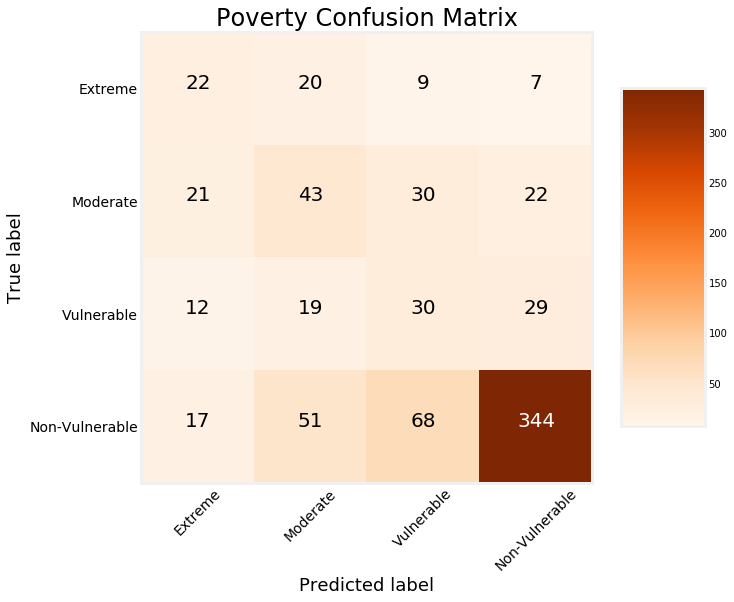

In [15]:
p_train, p_test, l_train, l_test = train_test_split(X_selected, y_train, random_state=42)
model.fit(p_train, l_train)
pred = model.predict(p_test)
cm = confusion_matrix(l_test, pred)

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

In [16]:
import shap
from IPython.display import display, HTML

shap.initjs()

def get_indexes(test_results, true_label, pred_label):
    return test_results[(test_results['Target']==true_label) & (test_results['Predicted']==pred_label)].index

def get_cofused_entries(df, test_results, true_label, pred_label):
    return df.loc[get_indexes(test_results, true_label, pred_label)]

def plot_influence_on_pred(df, shap_values, expected_value, index, classIndex):
    display(HTML("<h1>What influenced prediction for {}th sample</h1>".format(index+1)))
    if classIndex == 0:
        display(HTML("<h2>Prediction of class 1 (Extreme vulnerability) probability"))
        display(shap.force_plot(expected_value[0], shap_values[0][index], df.iloc[index,:]))
    elif classIndex == 1:
        display(HTML("<h2>Prediction of class 2 (Moderate vulnerability) probability"))
        display(shap.force_plot(expected_value[1], shap_values[1][index], df.iloc[index,:]))  
    elif classIndex == 2:            
        display(HTML("<h2>Prediction of class 3 (Vulnerable) probability"))
        display(shap.force_plot(expected_value[2], shap_values[2][index], df.iloc[index,:]))
    elif classIndex == 3:
        display(HTML("<h2>Prediction of class 4 (Non-vulnerable) probability")) 
        display(shap.force_plot(expected_value[3], shap_values[3][index], df.iloc[index,:]))          
    else:
        print("Error: classIndex out of bounds {}".format(classIndex))          



    
def sample_and_explain(df, number_of_samples, random_state, shap_values, expected_value, classIndex):
    for sample_id in df.sample(number_of_samples, random_state=random_state).index.values:
        index = df.index.get_loc(sample_id)
        plot_influence_on_pred(df, shap_values, expected_value, index, classIndex)

In [17]:
test_results = pd.DataFrame(data=l_test)
test_results['Predicted'] = pred

nonvul_as_moderate = get_cofused_entries(p_test, test_results, 4, 2)
moderate_as_nonvul = get_cofused_entries(p_test, test_results, 2, 4)

In [18]:
explainer = shap.TreeExplainer(model)

## Analizing True Non-vulnerable predicted as False Moderate

In [19]:
model.predict_proba(nonvul_as_moderate)

array([[0.08789177, 0.44330484, 0.0563669 , 0.41243649],
       [0.05016657, 0.54945714, 0.26513318, 0.13524311],
       [0.18406384, 0.4686645 , 0.14658693, 0.20068474],
       [0.1813023 , 0.32653921, 0.32379826, 0.16836024],
       [0.3817093 , 0.44480519, 0.12487202, 0.04861349],
       [0.14319562, 0.53573429, 0.16899416, 0.15207593],
       [0.14930662, 0.35867929, 0.30126802, 0.19074608],
       [0.05419035, 0.49540608, 0.23012174, 0.22028183],
       [0.27659171, 0.31214363, 0.28693476, 0.1243299 ],
       [0.24150629, 0.45251566, 0.13707008, 0.16890797],
       [0.13560488, 0.38807756, 0.23132094, 0.24499662],
       [0.21144442, 0.4000597 , 0.21140825, 0.17708764],
       [0.07557865, 0.47596752, 0.31385849, 0.13459534],
       [0.25584324, 0.50329667, 0.09770107, 0.14315903],
       [0.09000146, 0.44871277, 0.25327256, 0.20801321],
       [0.08930816, 0.57078281, 0.19141102, 0.14849801],
       [0.08400811, 0.47555662, 0.21526743, 0.22516784],
       [0.14429818, 0.62361426,

In [20]:
shap_values = explainer.shap_values(nonvul_as_moderate)
expected_value = explainer.expected_value

In [21]:
sample_and_explain(nonvul_as_moderate, 5, 42, shap_values, expected_value, 1)

In [22]:
shap.force_plot(expected_value[1], shap_values[1], nonvul_as_moderate)

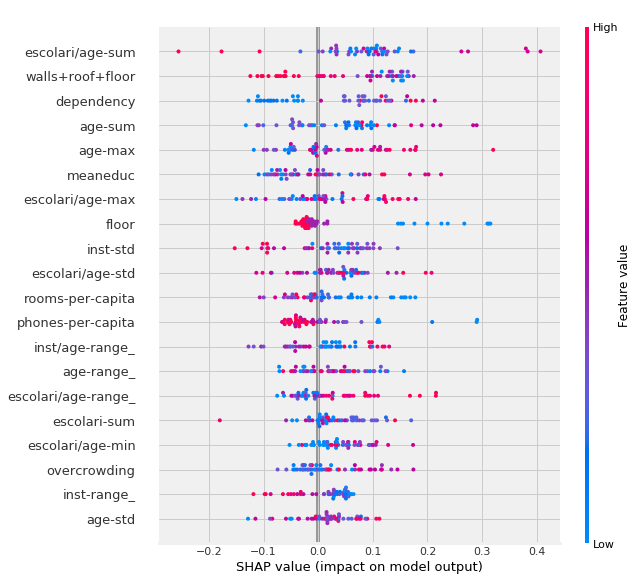

In [23]:
shap.summary_plot(shap_values[1], nonvul_as_moderate)

False Moderate prediction in the case are explained by low walls+roof+floor, high dependency, high age-sum, low escolari-min, high escolari/age-max, low floor, low rooms-per-capita, low phones-per-capita

### Experiment: changing the feature values

In [24]:
def test_change_in_ordinal_class_pred(model, df, class_true, feature_name, change_rate):
    df_experiment = df.copy()
    orig_class_pred = model.predict(df)
    orig_class_points = -1*abs(orig_class_pred - class_true)
    orig_class_points_sum = sum(orig_class_points)
    orig_class_diff_abs = abs(class_true - orig_class_pred)
    for change_index in range(1, 11):
        change = 1 + change_index*change_rate
        df_experiment[feature_name] = df[feature_name]*change
        class_pred = model.predict(df_experiment)
        class_diff_abs = abs(class_true - class_pred)
        class_points = -1*class_diff_abs
        class_points_sum = sum(class_points)
        class_change_pos = sum(class_diff_abs < orig_class_diff_abs)
        class_change_neg = sum(class_diff_abs > orig_class_diff_abs)
        class_points_change = class_points_sum - orig_class_points_sum
        print("{:.2f}% {} change: {} class points improvement, {} towards true, {} away true".format
              (change_index*change_rate*100, feature_name, class_points_change, class_change_pos, 
               class_change_neg))

In [30]:
test_change_in_ordinal_class_pred(model, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "escolari/age-sum", .1)

10.00% escolari/age-sum change: 5.0 class points improvement, 5 towards true, 1 away true
20.00% escolari/age-sum change: 13.0 class points improvement, 10 towards true, 1 away true
30.00% escolari/age-sum change: 13.0 class points improvement, 10 towards true, 1 away true
40.00% escolari/age-sum change: 13.0 class points improvement, 10 towards true, 0 away true
50.00% escolari/age-sum change: 12.0 class points improvement, 10 towards true, 0 away true
60.00% escolari/age-sum change: 12.0 class points improvement, 10 towards true, 0 away true
70.00% escolari/age-sum change: 17.0 class points improvement, 13 towards true, 1 away true
80.00% escolari/age-sum change: 17.0 class points improvement, 13 towards true, 0 away true
90.00% escolari/age-sum change: 18.0 class points improvement, 14 towards true, 0 away true
100.00% escolari/age-sum change: 20.0 class points improvement, 16 towards true, 1 away true


In [29]:
test_change_in_ordinal_class_pred(model, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "dependency", -.1)

-10.00% dependency change: 0.0 class points improvement, 0 towards true, 0 away true
-20.00% dependency change: 4.0 class points improvement, 2 towards true, 0 away true
-30.00% dependency change: 5.0 class points improvement, 3 towards true, 0 away true
-40.00% dependency change: 11.0 class points improvement, 6 towards true, 0 away true
-50.00% dependency change: 18.0 class points improvement, 11 towards true, 1 away true
-60.00% dependency change: 18.0 class points improvement, 11 towards true, 1 away true
-70.00% dependency change: 18.0 class points improvement, 11 towards true, 1 away true
-80.00% dependency change: 16.0 class points improvement, 10 towards true, 1 away true
-90.00% dependency change: 18.0 class points improvement, 11 towards true, 1 away true
-100.00% dependency change: 18.0 class points improvement, 10 towards true, 2 away true


In [33]:
test_change_in_ordinal_class_pred(model, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "age-sum", -.1)

-10.00% age-sum change: 8.0 class points improvement, 6 towards true, 2 away true
-20.00% age-sum change: 4.0 class points improvement, 4 towards true, 2 away true
-30.00% age-sum change: 7.0 class points improvement, 6 towards true, 2 away true
-40.00% age-sum change: 1.0 class points improvement, 4 towards true, 3 away true
-50.00% age-sum change: 4.0 class points improvement, 7 towards true, 4 away true
-60.00% age-sum change: -1.0 class points improvement, 4 towards true, 5 away true
-70.00% age-sum change: -4.0 class points improvement, 3 towards true, 7 away true
-80.00% age-sum change: -3.0 class points improvement, 5 towards true, 9 away true
-90.00% age-sum change: -6.0 class points improvement, 4 towards true, 12 away true
-100.00% age-sum change: -6.0 class points improvement, 4 towards true, 12 away true


In [34]:
test_change_in_ordinal_class_pred(model, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "age-sum", .1)

10.00% age-sum change: 4.0 class points improvement, 4 towards true, 0 away true
20.00% age-sum change: 6.0 class points improvement, 5 towards true, 0 away true
30.00% age-sum change: 8.0 class points improvement, 6 towards true, 0 away true
40.00% age-sum change: 8.0 class points improvement, 6 towards true, 0 away true
50.00% age-sum change: 6.0 class points improvement, 5 towards true, 0 away true
60.00% age-sum change: 4.0 class points improvement, 5 towards true, 1 away true
70.00% age-sum change: 5.0 class points improvement, 5 towards true, 1 away true
80.00% age-sum change: 5.0 class points improvement, 3 towards true, 0 away true
90.00% age-sum change: 5.0 class points improvement, 3 towards true, 0 away true
100.00% age-sum change: 3.0 class points improvement, 2 towards true, 0 away true


In [39]:
test_change_in_ordinal_class_pred(model, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "phones-per-capita", .1)

10.00% phones-per-capita change: 6.0 class points improvement, 3 towards true, 0 away true
20.00% phones-per-capita change: 10.0 class points improvement, 6 towards true, 0 away true
30.00% phones-per-capita change: 10.0 class points improvement, 6 towards true, 0 away true
40.00% phones-per-capita change: 10.0 class points improvement, 6 towards true, 0 away true
50.00% phones-per-capita change: 10.0 class points improvement, 6 towards true, 0 away true
60.00% phones-per-capita change: 9.0 class points improvement, 5 towards true, 0 away true
70.00% phones-per-capita change: 11.0 class points improvement, 6 towards true, 0 away true
80.00% phones-per-capita change: 11.0 class points improvement, 6 towards true, 0 away true
90.00% phones-per-capita change: 13.0 class points improvement, 7 towards true, 0 away true
100.00% phones-per-capita change: 13.0 class points improvement, 7 towards true, 0 away true


## Analizing True Moderate predicted as False Non-vulnerable

In [26]:
shap_values = explainer.shap_values(moderate_as_nonvul)
expected_value = explainer.expected_value
sample_and_explain(moderate_as_nonvul, 5, 42, shap_values, expected_value, 3)

In [27]:
shap.force_plot(expected_value[3], shap_values[3], moderate_as_nonvul)

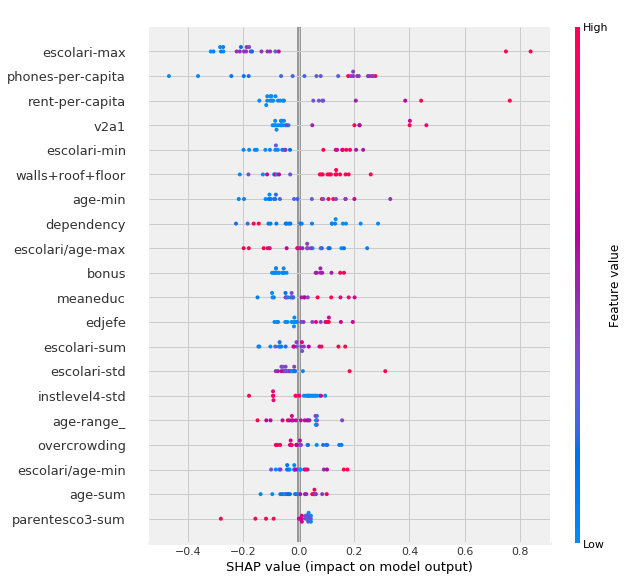

In [28]:
shap.summary_plot(shap_values[3], moderate_as_nonvul)

False Non-vulnerable prediction in the case are explained by high phones-per-capita, high rent-per-capita, high v2a1, high escolari-min, high walls+roof+floor, low dependency, low escolari/age-min, high bonus, hight meaneduc, high edjefe. 

Also we can see two obs. with extreme high influence of high escolari-max feature, and one obs. with extreme high influence of rent-per-capita feature.

### Experiment: changing the feature values

In [45]:
test_change_in_ordinal_class_pred(model, moderate_as_nonvul, 
                                  np.full((moderate_as_nonvul.shape[0]), 2), "phones-per-capita", -.1)

-10.00% phones-per-capita change: 3.0 class points improvement, 2 towards true, 0 away true
-20.00% phones-per-capita change: 3.0 class points improvement, 2 towards true, 0 away true
-30.00% phones-per-capita change: 8.0 class points improvement, 5 towards true, 0 away true
-40.00% phones-per-capita change: 11.0 class points improvement, 7 towards true, 0 away true
-50.00% phones-per-capita change: 11.0 class points improvement, 7 towards true, 0 away true
-60.00% phones-per-capita change: 12.0 class points improvement, 8 towards true, 0 away true
-70.00% phones-per-capita change: 11.0 class points improvement, 7 towards true, 0 away true
-80.00% phones-per-capita change: 11.0 class points improvement, 8 towards true, 0 away true
-90.00% phones-per-capita change: 11.0 class points improvement, 8 towards true, 0 away true
-100.00% phones-per-capita change: 11.0 class points improvement, 8 towards true, 0 away true


In [48]:
test_change_in_ordinal_class_pred(model, moderate_as_nonvul, 
                                  np.full((moderate_as_nonvul.shape[0]), 2), "dependency", .1)

10.00% dependency change: 0.0 class points improvement, 0 towards true, 0 away true
20.00% dependency change: 3.0 class points improvement, 2 towards true, 0 away true
30.00% dependency change: 3.0 class points improvement, 2 towards true, 0 away true
40.00% dependency change: 3.0 class points improvement, 2 towards true, 0 away true
50.00% dependency change: 5.0 class points improvement, 3 towards true, 0 away true
60.00% dependency change: 6.0 class points improvement, 4 towards true, 0 away true
70.00% dependency change: 6.0 class points improvement, 4 towards true, 0 away true
80.00% dependency change: 6.0 class points improvement, 4 towards true, 0 away true
90.00% dependency change: 6.0 class points improvement, 4 towards true, 0 away true
100.00% dependency change: 6.0 class points improvement, 4 towards true, 0 away true
